# Insurance Data
This Jupyter Notebook takes an insurance data set from Kaggle and looks into the relationships between the different parameters given. First, we check for a correlation (a linear relationship) between BMI and insurance charges, and then we see if being a smoker influences what you're charged by insurance companies using an A/B Test.

In [1]:
# Import datascience and numpy, define some important functions, and read the table

from datascience import *
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# regression functions
def standard_units(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def correlation(x, y):
    return np.mean(standard_units(x) * standard_units(y))

def slope(x, y):
    r = correlation(x, y)
    return r * np.std(y) / np.std(x)

def intercept(x, y):
    m = slope(x, y)
    return np.mean(y) - m * np.mean(x)

# read table
insurance = Table.read_table('insurance.csv')
insurance

age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.9
18,male,33.77,1,no,southeast,1725.55
28,male,33,3,no,southeast,4449.46
33,male,22.705,0,no,northwest,21984.5
32,male,28.88,0,no,northwest,3866.86
31,female,25.74,0,no,southeast,3756.62
46,female,33.44,1,no,southeast,8240.59
37,female,27.74,3,no,northwest,7281.51
37,male,29.83,2,no,northeast,6406.41
60,female,25.84,0,no,northwest,28923.1


### Is there a correlation (a linear relationship) between BMI and insurance charges?
Correlation is calculated by taking two data points, putting them in standard units, multiplying the coordinates elementwise, and then finding the mean (all of this is defined in the `correlation` function in the first cell). The value of $r$, heretofore referred to as correlation, ranges from -1 to 1; a value near 1 indicates a positive linear relationship (i.e. a line with a positive slope), near -1 indicates a negative linear relationship, and near 0 indicates little/no linear relationship.

0.1983409688336289


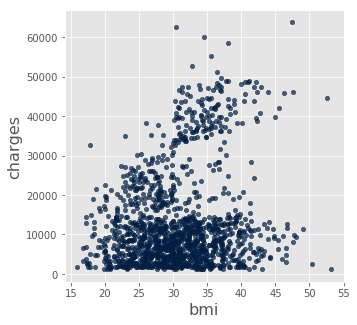

In [3]:
print(correlation(insurance.column('bmi'), insurance.column('charges')))
insurance.scatter('bmi', 'charges')

Based on the fact that the value of $r$ was around 0.2, there might be a _small_ correlation between BMI and insurance charges, but the relationship is not as strong as it could be among other data points.

### Does being a smoker affect what you're charged by the insurance company?
**Null Hypothesis**: Being a smoker does not affect your charges; any differences in the observed values are due to random chance.

**Alternative Hypothesis**: Being a smoker _does_ affect what you are charged in insurance premiums.

This question, from a data science perspective, is asking whether or not the charges for the groups `smoker` and `non-smoker` come from the same underlying distribution. To find this out, we use an A/B Test, which involves shuffling up the data in question in a sample _without replacement_, computing a test statistic, and finding the p-value. By convention, if the p-value is less than .05 (meaning less than 5% of the simulated data point in the same direction as the original data set), we lean in the direction of the alternative hypothesis. In this A/B test, the test statistic will be the absolute difference between the mean charges for smokers and non-smokers.

In [4]:
# This is a single permutation of the sample; this will be done many times later in the actual permutation test;
# this cell is meant to give an idea of how the sample will be permuted.

i = insurance.select('smoker', 'charges')

shuffled = i.sample(with_replacement=False).column('charges')
i_shuffled = i.with_column('shuffled charges', shuffled).relabeled('charges', 'original charges')
i_shuffled.group(0, np.mean)

smoker,original charges mean,shuffled charges mean
no,8434.27,13443.6
yes,32050.2,12597.8


In [5]:
# for an idea of what the input of the ts function will be (see next cell)

i_shuffled

smoker,original charges,shuffled charges
yes,16884.9,3268.85
no,1725.55,10197.8
no,4449.46,13390.6
no,21984.5,32734.2
no,3866.86,1639.56
no,3756.62,8551.35
no,8240.59,10118.4
no,7281.51,5253.52
no,6406.41,2719.28
no,28923.1,44260.7


In [7]:
# defining the function ts that will compute the test statistic given a shuffled table like the one above

def ts(tbl):
    t = tbl.group(0, np.mean)
    return abs(t.column(2).item(0) - t.column(2).item(1))


# computing the test statistic on the table i_shuffled

i_ts = ts(i_shuffled)
i_ts

845.821103053846

In [16]:
# defining a function perm_test which does the permutation test on the data set; takes the table i (which contains
# the smoker and charges columns from the insurance table) as an argument as well as the number of repetitions;
# function returns the p-value

def perm_test(tbl, reps):
    stats = make_array()
    for i in np.arange(reps):
        shuffled = tbl.sample(with_replacement=False).column(1)
        t = tbl.with_column('shuffled', shuffled)
        stat = ts(t)
        stats = np.append(stats, stat)
        
    observed_ts = abs(tbl.group(0, np.mean).column(1).item(0) - tbl.group(0, np.mean).column(1).item(1))
    
    return np.count_nonzero(stats >= observed_ts) / len(stats)

In [18]:
perm_test(i, 10000)

0.0

**Conclusion**: Because the p-value is 0, we know that _none_ of the shuffled sets were as far or farther in the direction of the alternative hypothesis than was the original data set; this means that in all likelihood, the observed differences are _not_ due to random chance. Thus, we lean in the direction of the alternative hypothesis: that being a smoker affects what you're charged by insurance companies. Conventional wisdom, I know, but it is still nice to have it proven empirically.